<a href="https://colab.research.google.com/github/ShaheryarEhsan/ML_Labs/blob/main/Convolutional_Neural_Network_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchvision

In [ ]:
import numpy as np
import math
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
import torch
import torchvision
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

We will define the size of the batch and the number of times the algorithm will go over the dataset.

In [ ]:
n_epochs = 5
batch_size_train = 128
batch_size_test = 2000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Loading certain samples

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

What does an example look like?

In [ ]:
example_data.shape

torch.Size([2000, 1, 28, 28])

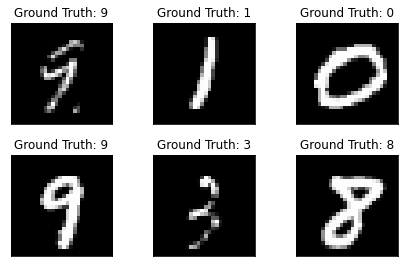

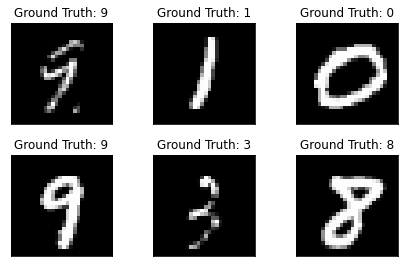

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

Creating a Convolutional Neural Network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

Initializing the network and optimizer

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

Training the Network

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

Training Function

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

Testing Function

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Training

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3039, Accuracy: 993/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319622
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.297673
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.310723
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.278937
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.289087
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.258600
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.233088
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.224965
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.192059
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.155639
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.134820
Train Epoch: 1 [14080/60000 (23%)]	Loss: 2.060236
Train Epoch: 1 [15360/60000 (26%)]	Loss: 2.034682
Train Epoch: 1 [16640/60000 (28%)]	Loss: 1.898158
Train Epoch: 1 [17920/60000 (30%)]	Loss: 1.824237
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.799909
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.649823
Train Epoch: 1 [21760/60000 (36%)]	Loss: 1.515778
Train Epoch: 1 [23040/60000 (38%)]	Loss: 1.565687
Train Epo

Plotting the performance of the network

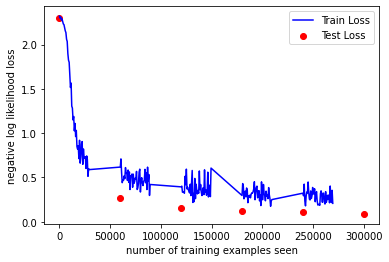

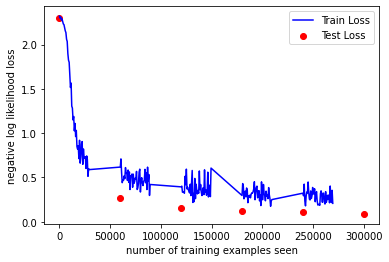

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [ ]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


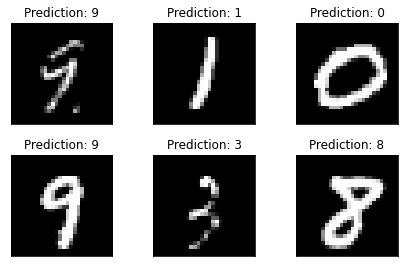

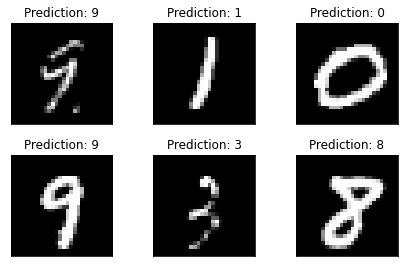

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

Compared to KNN classifer on the same MNIST dataset, a CNN has greater accuracy depending upon the number of times it has been trained on the data. My previous lab used Euclidean and Cosine Similarity formulas to calculate accuracy but my CNN is better than both at 97% accuracy.